In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image,ImageOps
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model, Sequential

### 1. Dataset configuration

In [2]:
input_path = "./dataset/"
target_size = [224, 224, 3]

In [3]:
# train configuration
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=32,
    target_size=(target_size[0],target_size[1]))

# test configuration
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    input_path + 'test',
    shuffle=False,
    target_size=(target_size[0],target_size[1]))

Found 448 images belonging to 4 classes.
Found 420 images belonging to 4 classes.


In [4]:
class_labels = train_generator.class_indices

print(class_labels)

{'Ambulance': 0, 'Bicycle': 1, 'Bus': 2, 'Car': 3}


### 2. The model

In [5]:
from tensorflow.keras.applications.resnet import ResNet50

pretrained_model = ResNet50(
    input_shape = (target_size[0],
                   target_size[1],
                   target_size[2]), 
    weights = 'imagenet', 
    include_top = False)

pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(len(class_labels)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

### 3. Train

In [6]:
# Compile and fit your model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit_generator(train_generator,
                     steps_per_epoch = 10,
                     epochs = 3,
                     validation_data = validation_generator,
                     validation_steps = 4)

C:\Users\medha\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\medha\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Epoch 1/3
10/10 [==============================] - 41s 4s/step - loss: 5.3505 - accuracy: 0.7875 - val_loss: 6.7736 - val_accuracy: 0.8828
Epoch 2/3
10/10 [==============================] - 39s 4s/step - loss: 2.7254 - accuracy: 0.9531 - val_loss: 0.6005 - val_accuracy: 0.9844
Epoch 3/3
10/10 [==============================] - 39s 4s/step - loss: 2.6681 - accuracy: 0.9531 - val_loss: 4.0960 - val_accuracy: 0.9375


### 4. Model evaluation

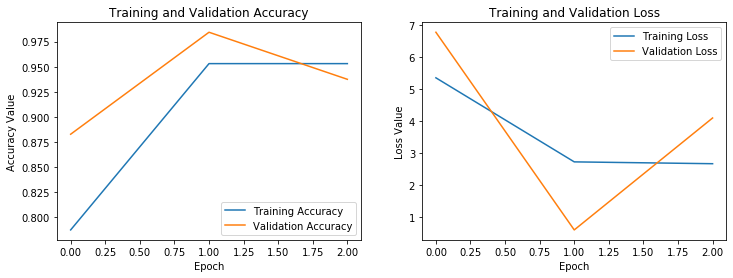

In [7]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

### ٍSave the model

In [8]:
model.save('vehicle_4.h5')

### convert the model to tensorflow lite

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
open('vehicle_4.tflite', 'wb').write(converter.convert())

### Load the model and test

In [10]:
model = load_model('vehicle_4.h5')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix \n')
print(confusion_matrix(validation_generator.classes, y_pred))


Confusion Matrix 

[[ 19   0   1   0]
 [  0 109   0   7]
 [  3   0 165   8]
 [  1   2   0 105]]


In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50

# function to return key for any value
def get_key(val):
    for key, value in class_labels.items():
         if val == value:
            return key
        
def image_prediction(image_path):
    data = np.ndarray(shape=(1, target_size[0], target_size[1], 3), dtype=np.float32)
    img = Image.open(image_path)
    img = ImageOps.fit(img, (target_size[0], target_size[1]), Image.ANTIALIAS)
    image_array = np.asarray(img)
    
    imgplot = plt.imshow(image_array)
    plt.show()
    
    car_img = image.load_img(image_path, target_size=(224, 224))
    X = image.img_to_array(car_img)
    X = np.expand_dims(X, axis=0)
    X = resnet50.preprocess_input(X)
     
    model.predict(X).argmax()
    
    return get_key(model.predict(X).argmax())



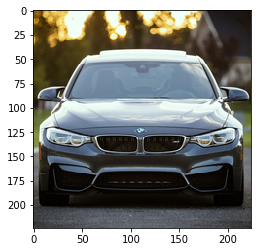

'Car'

In [13]:

image_path = "./dataset/train/Car/photo-1441148345475-03a2e82f9719.jfif"


image_prediction(image_path)